In [1]:
import sys

print(sys.version)

3.12.1 (main, Sep 30 2024, 17:05:21) [GCC 9.4.0]



(Introduction to Aerospace Flight Vehicles Copyright © 2022–2024 by J. Gordon Leishman is licensed under a Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License)

https://eaglepubs.erau.edu/introductiontoaerospaceflightvehicles/chapter/takeoff-landing-performance/

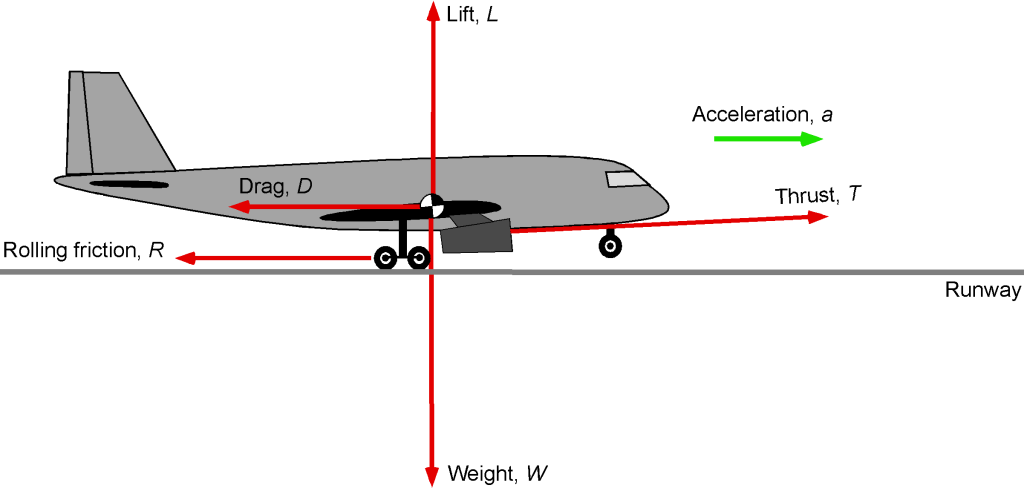

Eq. 1:
$$
R = \mu_r(W-L)
$$



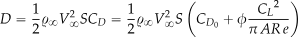

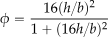

Net accelerating force on the airplane from Eq 5:
$$
T - R - D = T - \mu_r(W - L) - D = F
$$

Next I will break Eq 5 in terms of accelerations in X and Y.

It turns out that Eq. 5 is the forces along the axis of the plane, so basically 1 dimension (x)

Actually, I guess it assumes a reference frame fixed to the plane, along the plane's axis. And forces are acting on the point mass.

The forces transverse to the plane are: 

$$
L - W = F_{transverse}
$$

I'll model the forces relative to the point mass where positive x is forward of the plane along its direction of travel and positive y is perpedicular along the direction of lift.

$$
\ddot{p_{axial}} = (T - R - D)/m
$$

$$
\ddot{p_{transverse}} = (L - W)/m
$$

In [2]:
# Import the required modules
import numpy as np
import matplotlib.pyplot as plt


from scipy.integrate import solve_ivp   # Now preferred to odeint

global constants
constants: dict = {
    'g': 9.81, # m/s^2
    'm': 377842.4, # kg - https://www.researchgate.net/figure/General-specifications-of-the-BOEING-747-200-aircraft-1_tbl4_349651022
    'mu': 0.02, # TODO: find this value
    'a': 510.97, # m^2 - https://aerospaceweb.org/question/aerodynamics/q0252.shtml
    'rho': 1.2250, # kg/m^3 - assumes sea level - https://www.eoas.ubc.ca/courses/atsc113/flying/met_concepts/02-met_concepts/02a-std_atmos-P/index.html
    'Cl': 1 # TODO: find this value # Coefficient of Lift
}


# Define the initial conditions

x_pos_0 = 0.0
y_pos_0 = 0.0
vx_0 = 0.0
vy_0 = 0.0


def f_W(mass, g):
    return mass * g

def f_L(coef_lift, area_lift, rho, vx): 
    return coef_lift * area_lift * .5 * rho * vx**2

def f_T():
    ''' The Thrust force, or the force propelling the aircraft forward '''
    return 500_000.0 #TBD

def f_R(vx, N):
    ''' The rolling resistance force, or the force opposing the motion of the aircraft due to friction with the wheels and the ground '''
    '''if vx != 0:
        return constants['mu'] * N * -np.sign(vx)
    else:
        return 0'''
    return 0    

def f_N(W, L):
    ''' The normal force, or the restoring force of the ground on the plane '''
    return max(W - L, 0.0)

def f_D(vx):
    ''' The Drag force, or the force opposing the motion of the aircraft due to air resistance '''
    return 0.5 * constants['rho'] * vx**2 * 1.0 # TODO: find this value
    
# Define the function that represents the right-hand side of the ODE
def f_axial(T, R, D):
    ''' The Axial force, or the force in the direction of motion.
        T is the thrust force, R is the rolling resistance force, and D is the drag force.
        R is added because the function calculating R already includes adding the opposite sign of the velocity.'''  
    return (T + R - D)

def f_transverse(W, L, N):
    ''' The transverse force, or the force perpendicular to the direction of motion '''
    return (L - W + N)

def equations_of_motion(t, y):
    ''' The equations of motion for the aircraft. 
        The state vector y is [x, y, vx, vy] where x and y are the position coordinates, and vx and vy are the velocities in the x and y directions respectively. 
        The function returns the derivatives of the state vector, and a dictionary of the values of the forces at that time.'''

    pos_x, pos_y, vx, vy = y
    W=f_W(constants['m'], constants['g'])
    L=f_L(constants['Cl'], constants['a'], constants['rho'], vx)
    N=f_N(W, L)
    T=f_T()
    D=f_D(vx)
    R=f_R(vx, N)
    #log_signals(t, pos_x=pos_x, pos_y=pos_y, vx=vx, vy=vy, W=W, L=L, N=N, T=T, D=D, R=R)


    dxdt = vx
    dydt = vy
    dvxdt = f_axial(T, R, D)/constants['m']
    dvydt = f_transverse(W, L, N)/constants['m']

    return [dxdt, dydt, dvxdt, dvydt], {'W': W, 'L': L, 'N': N, 'T': T, 'D': D, 'R': R}

def system_derivatives(t, y):
    return equations_of_motion(t, y)[0]

def system_algebraic_states(t, y):
    return equations_of_motion(t, y)[1]


In [3]:
# Define the time points for which the solution is to be computed
duration_s = 300
t_span = (0, duration_s)

# Define the initial conditions
initial_conditions = [x_pos_0, y_pos_0, vx_0, vy_0] 

# Solve the ODE
solution = solve_ivp(system_derivatives, t_span, initial_conditions, dense_output=True, max_step=0.1)

# Extract the results
x = solution.y[0]
y = solution.y[1]


In [4]:
import pandas as pd

# Initialize an empty DataFrame to store signals
signals_df = pd.DataFrame(columns=['time', 'signal_name', 'value'])

# Function to log multiple signals at a given time using kwargs
def log_signals(df, t, **kwargs):
    new_entries = pd.DataFrame({
        'time': [t] * len(kwargs),
        'signal_name': list(kwargs.keys()),
        'value': list(kwargs.values())
    })
    return pd.concat([df, new_entries], ignore_index=True)

# Function to get the signal values for a given signal name, sorted by time
def get_signal_ts(df, signal_name):
    return df[df['signal_name'] == signal_name].sort_values(by='time')

def plot_signal_ts(df, signal_name):
    return get_signal_ts(df, signal_name).plot(x='time', y='value', title=signal_name, ylabel=signal_name)

# Function to get a list of distinct signal names
def get_distinct_signal_names(df):
    return df['signal_name'].unique().tolist()

def plot_all_signals(df):
    for signal_name in get_distinct_signal_names(df):
        plot_signal_ts(df, signal_name)

In [5]:
for t in solution.t:
    signals_df = log_signals(signals_df, t, x=solution.sol(t)[0], y=solution.sol(t)[1], vx=solution.sol(t)[2], vy=solution.sol(t)[3])
    signals_df = log_signals(signals_df, t, **system_algebraic_states(t, solution.sol(t)))

/tmp/ipykernel_40337/3533097515.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, new_entries], ignore_index=True)


<Axes: title={'center': 'x'}, xlabel='time', ylabel='x'>

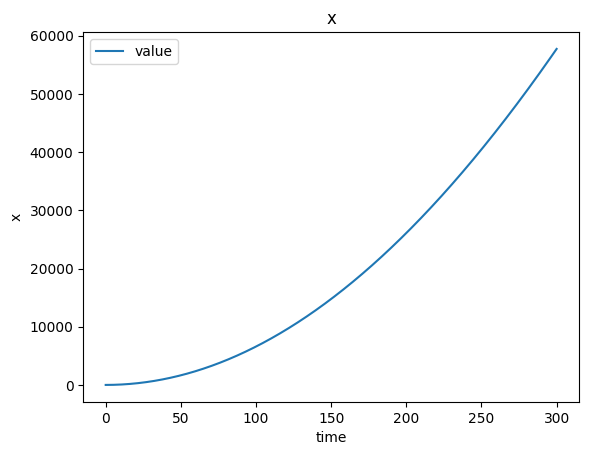

In [6]:
test=get_signal_ts(signals_df,'x').min()
plot_signal_ts(signals_df, 'x')

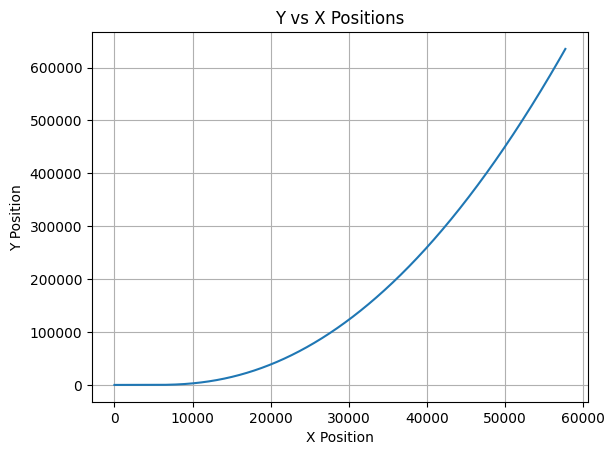

In [ ]:
plt.figure()
plt.plot(x, y)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Y vs X Positions')
plt.grid(True)
plt.show()

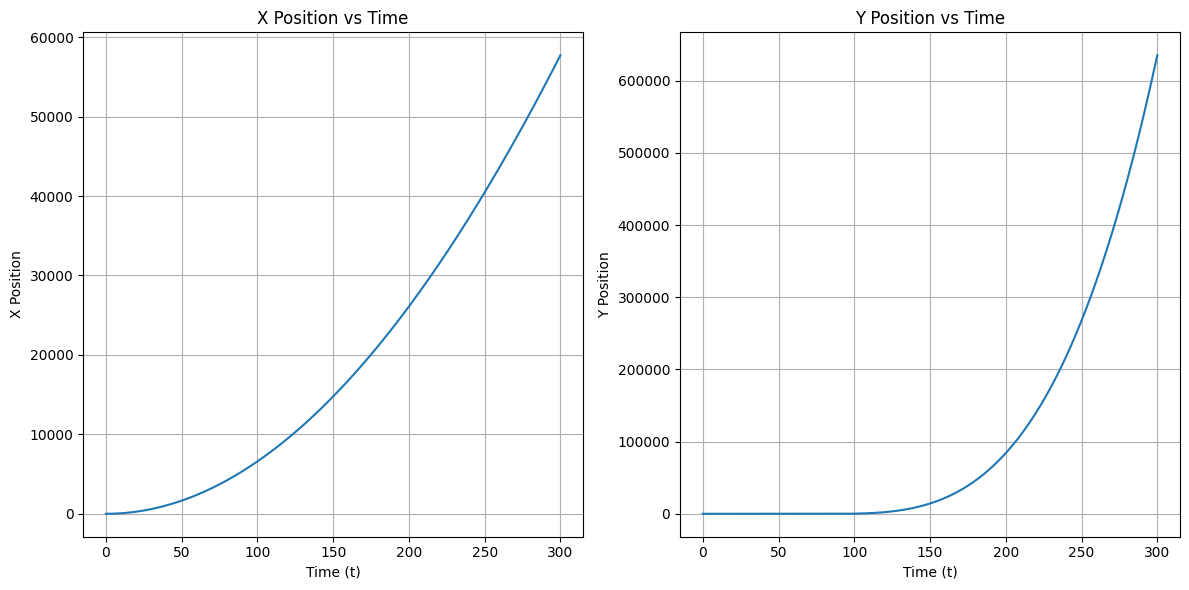

In [ ]:
plt.figure(figsize=(12, 6))

# Plot x vs t
plt.subplot(1, 2, 1)
plt.plot(solution.t, x)
plt.xlabel('Time (t)')
plt.ylabel('X Position')
plt.title('X Position vs Time')
plt.grid(True)

# Plot y vs t
plt.subplot(1, 2, 2)
plt.plot(solution.t, y)
plt.xlabel('Time (t)')
plt.ylabel('Y Position')
plt.title('Y Position vs Time')
plt.grid(True)

plt.tight_layout()
plt.show()

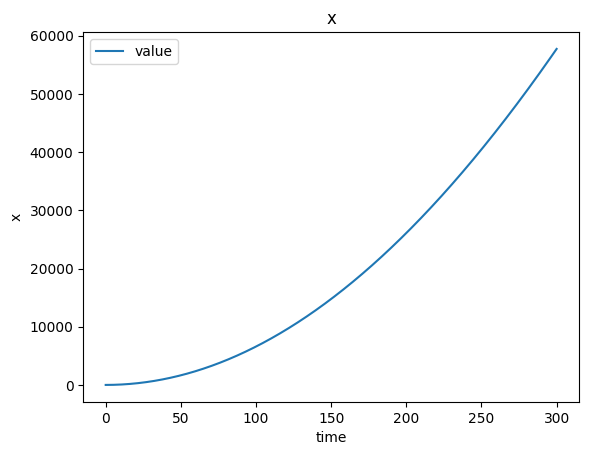

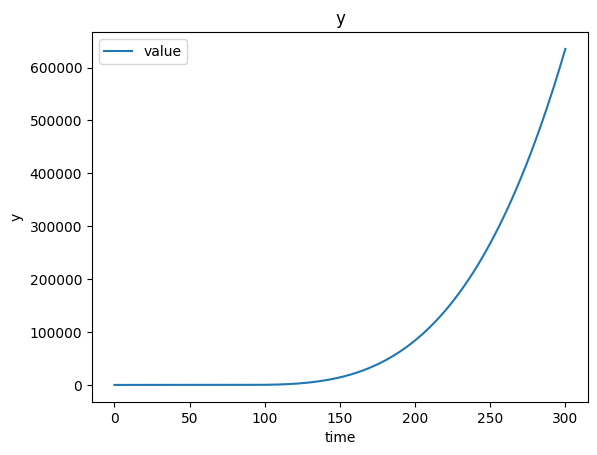

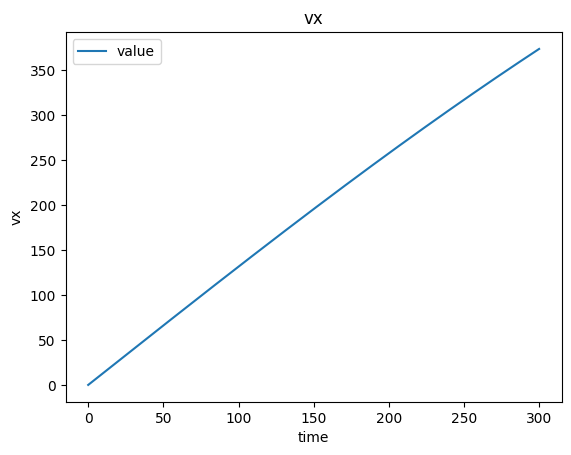

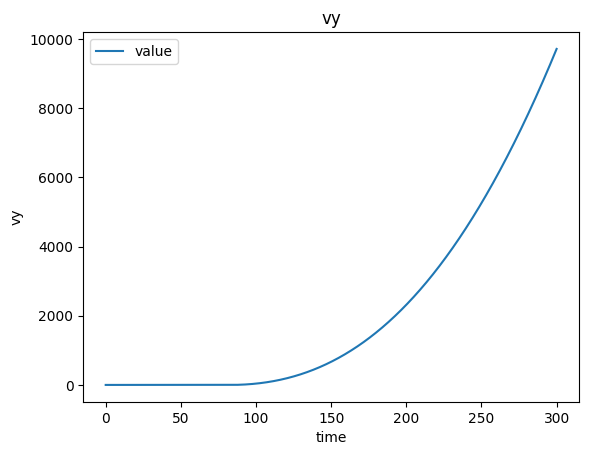

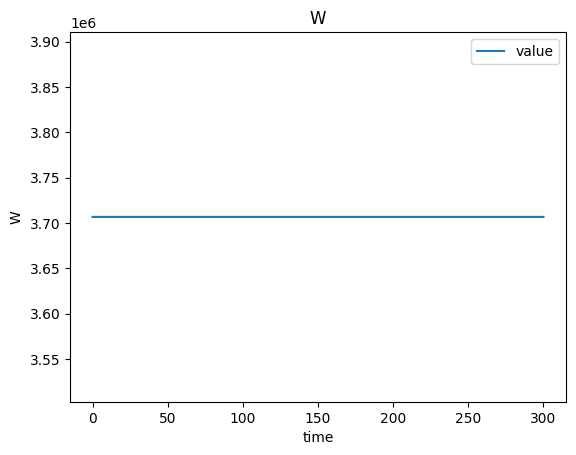

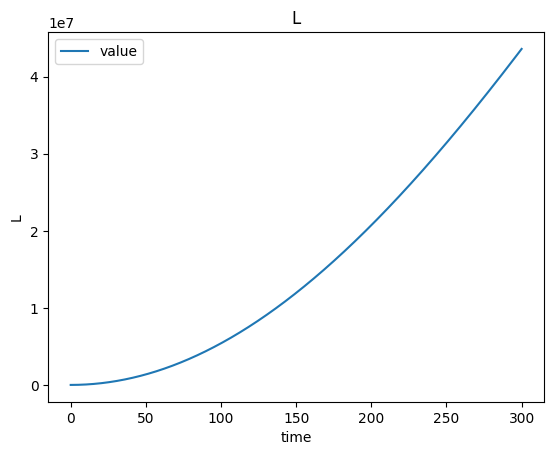

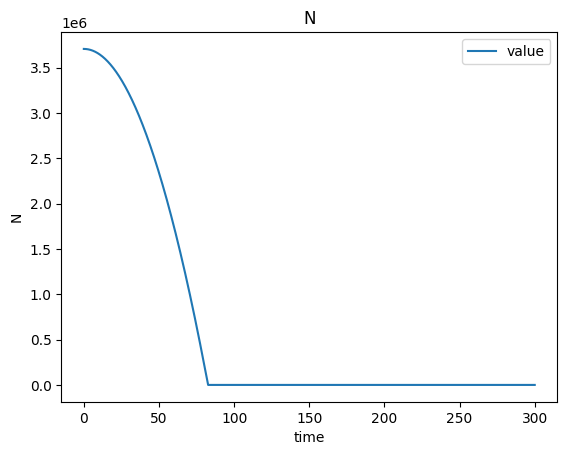

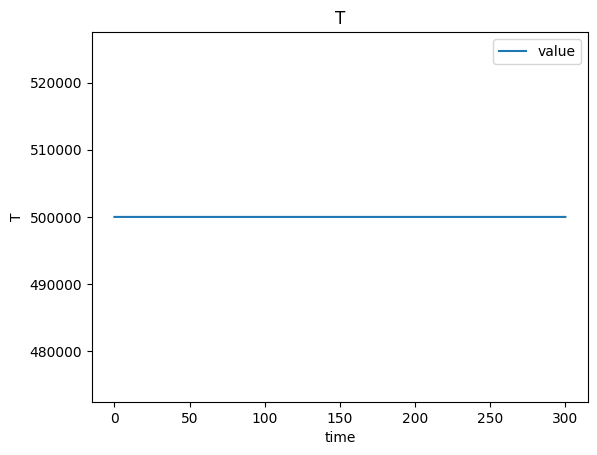

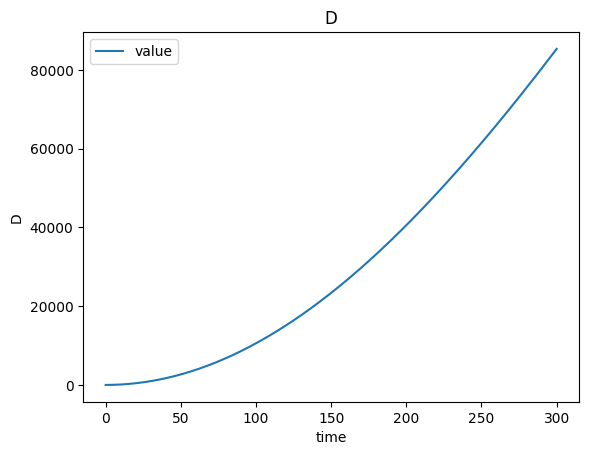

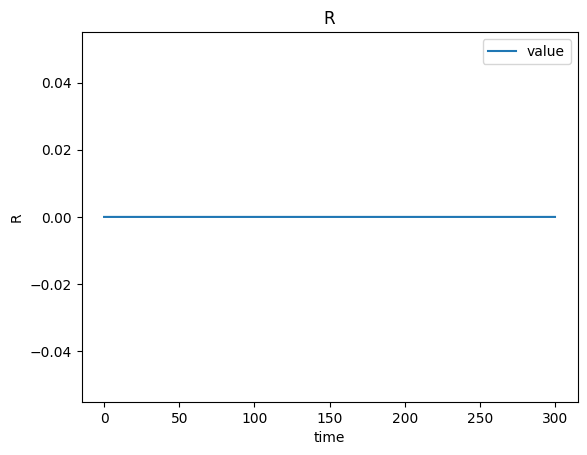

In [9]:
plot_all_signals(signals_df)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import animation
from IPython.display import HTML


# create background figure and axes
sns.set_theme(font_scale=1.5)
fig, ax = plt.subplots(figsize=(8,8))

# don't show the plain background
plt.close()


In [11]:
from math import floor
def drawframe(anim_frame, num_anim_frames, df):
    which_frame = floor(anim_frame/num_anim_frames*len(df['time']))
    x = get_signal_ts(df, 'x')[:which_frame]
    y = get_signal_ts(df, 'y')[:which_frame]
    
    # Plot the trace up to the current frame
    ax.plot(x, y, marker='o')
    
    return ax.lines

In [12]:
# create animiation object and render in HTML video

anim_hz = 1
num_anim_frames = duration_s * anim_hz

# resample solution for animation
# Initialize an empty DataFrame to store signals
anim_df = pd.DataFrame(columns=['time', 'signal_name', 'value'])

for n in range(num_anim_frames):
    t = n / num_anim_frames * duration_s
    log_signals(anim_df, t, x=solution.sol(t)[0], y=solution.sol(t)[1], vx=solution.sol(t)[2], vy=solution.sol(t)[3])
    log_signals(anim_df, t, **system_algebraic_states(t, solution.sol(t)))

from functools import partial

ax.clear()
ax.set_xlim((get_signal_ts(anim_df, 'x')['value'].min(), get_signal_ts(anim_df, 'x')['value'].max()))
ax.set_ylim((get_signal_ts(df, 'y')['value'].min(), get_signal_ts(df, 'y')['value'].max()))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Y vs X')

anim = animation.FuncAnimation(fig, partial(drawframe, num_anim_frames=num_anim_frames, df=anim_df), frames=num_anim_frames, interval=1/anim_hz*10**3, blit=True)
#HTML(anim.to_html5_video())
HTML(anim.to_jshtml())


/tmp/ipykernel_40337/3533097515.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, new_entries], ignore_index=True)


NameError: name 'df' is not defined